<a href="https://colab.research.google.com/github/institutohumai/cursos-python/blob/master/MachineLearning/9_SeriesDeTiempo/2.Prophet.ipynb"> <img src='https://colab.research.google.com/assets/colab-badge.svg' /> </a>
<div align="center"> Recordá abrir en una nueva pestaña </div>

# Prophet

In [46]:
import itertools
import numpy as np
import pandas as pd
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_plotly
from matplotlib import pyplot as plt
from plotly import offline as py
plt.rcParams["figure.figsize"] = (20,5)


In [2]:
# importamos datos abiertos del servicio de meteorologia y atmósfera
# link: https://www.ncdc.noaa.gov/data-access
# datos anuales desde 1880 a 2021

## Trabando sobre datos climáticos
importamos datos abiertos del servicio de meteorologia y atmósfera

link: https://www.ncdc.noaa.gov/data-access

datos anuales desde 1880 a 2021

In [47]:
data = pd.read_csv('https://datasets-humai.s3.amazonaws.com/datasets/monthly_temp.csv')
data.ds = pd.to_datetime(data.ds)
train = data.copy()
train.head(10)

,ds,y
0,1895-01-01,26.69
1,1895-02-01,26.60
2,1895-03-01,39.97
3,1895-04-01,52.90
4,1895-05-01,59.94
5,1895-06-01,67.80
6,1895-07-01,71.24
7,1895-08-01,71.62
8,1895-09-01,65.57
9,1895-10-01,50.85


In [48]:
train.tail(10)

,ds,y
1509,2020-10-01,54.30
1510,2020-11-01,46.33
1511,2020-12-01,35.73
1512,2021-01-01,34.59
1513,2021-02-01,30.58
1514,2021-03-01,45.54
1515,2021-04-01,51.85
1516,2021-05-01,60.35
1517,2021-06-01,72.63
1518,2021-07-01,75.47


In [49]:
# generamos un dataset futuro para hacer la prediccion, desde
# 2021 a 2090
futuro = pd.DataFrame({'ds': pd.to_datetime(
    [x for x in range(2021, 2090)], format='%Y'), 'y': np.nan})

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


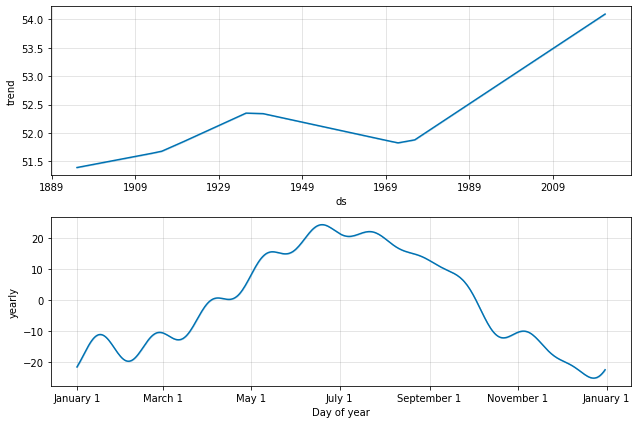

In [33]:
# instanciamos modelo
m = Prophet()

# fiteamos el modelo en TRAIN
m.fit(train)

# predecimos en futuro
forecast = m.predict(futuro)

# para graficar, hacemos predict tambien en train
forecast_train = m.predict(train)

# #unimos los dos DFs para visualizar las dos partes, train-prediccion
forecast_final = pd.concat([forecast_train, forecast])

# #plot componentes del forecast
m.plot_components(forecast_train);

In [34]:
# vemos como prophet captura la estacionalidad anual y la tendencia creciente.

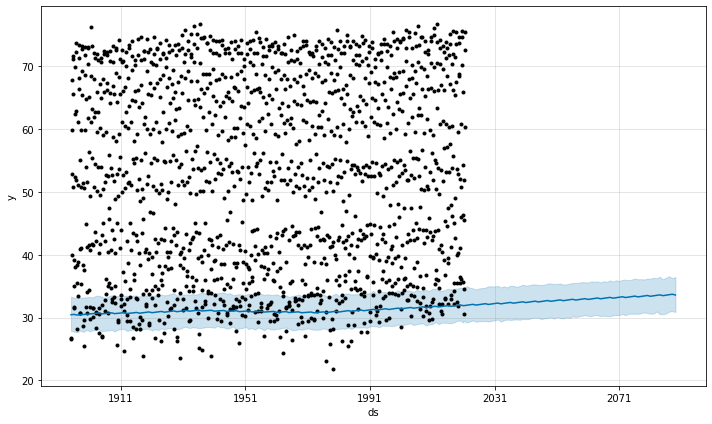

In [50]:
m.plot(forecast_final[forecast_final['ds'].dt.month==1])
plt.show()

In [42]:
# podemos pasar una grilla de hiperparámetros y probar con rolloing cross validation
# el set que minimiza el error. En este caso el MAE. Luego repetimos la prediccion
# con el mejor set de hiperparámetros.

# nombrar hiperparametros mas importantes, changepoint_prior_scale y changepoint range. como funcionan.
# prophet tambine puede recibir regresores de una matriz de datos.
# fechas de feriados para argentina y otros paises, etc.


param_grid = {
    'changepoint_prior_scale': [0.001, 0.05],  # default 0.05
    'seasonality_prior_scale': [10.0, 0.01, 1.0],  # default 10
    'seasonality_mode': ["additive", "multiplicative"]}


# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v))
              for v in itertools.product(*param_grid.values())]
maes = []  # Store the MAEs for each params here
counter = 1
# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params)
    print(counter)
    counter = counter + 1

    m.fit(train)  # Fit model with given params

    initial_forecast_date = '1980-01-01'
    initial = str(
        abs(data[data.ds > initial_forecast_date].shape[0] - data.shape[0])) + ' days'

# tendremos 100 años de entrenamiento fijos
# luego haremos predicciones cada 10 años de 5 años de ventana de prediccion
# sucesivamente hasta que los datos se agoten.

    df_cv = cross_validation(
        m, initial='36500 days', period='3650 days', horizon='1825 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=5)
    # rmses.append(df_p['rmse'].values[0])
    maes.append(df_p['mae'].values[0])  # USAMOS EL MAE


tuning_results = pd.DataFrame(all_params)

tuning_results['mae'] = maes
print(tuning_results)
best_params = all_params[np.argmin(maes)]
print(best_params)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


1


INFO:fbprophet:Making 3 forecasts with cutoffs between 1996-07-07 00:00:00 and 2016-07-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f665f300c10>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2


INFO:fbprophet:Making 3 forecasts with cutoffs between 1996-07-07 00:00:00 and 2016-07-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f6659cf5950>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


3


INFO:fbprophet:Making 3 forecasts with cutoffs between 1996-07-07 00:00:00 and 2016-07-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f665f134550>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


4


INFO:fbprophet:Making 3 forecasts with cutoffs between 1996-07-07 00:00:00 and 2016-07-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f6659cf5950>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


5


INFO:fbprophet:Making 3 forecasts with cutoffs between 1996-07-07 00:00:00 and 2016-07-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f66599febd0>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


6


INFO:fbprophet:Making 3 forecasts with cutoffs between 1996-07-07 00:00:00 and 2016-07-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f6659cde050>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


7


INFO:fbprophet:Making 3 forecasts with cutoffs between 1996-07-07 00:00:00 and 2016-07-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f6659726bd0>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


8


INFO:fbprophet:Making 3 forecasts with cutoffs between 1996-07-07 00:00:00 and 2016-07-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f6659d3ed90>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


9


INFO:fbprophet:Making 3 forecasts with cutoffs between 1996-07-07 00:00:00 and 2016-07-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f6659748b10>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


10


INFO:fbprophet:Making 3 forecasts with cutoffs between 1996-07-07 00:00:00 and 2016-07-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f66598e4e10>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


11


INFO:fbprophet:Making 3 forecasts with cutoffs between 1996-07-07 00:00:00 and 2016-07-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f665f297710>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


12


INFO:fbprophet:Making 3 forecasts with cutoffs between 1996-07-07 00:00:00 and 2016-07-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f66598e4a90>


    changepoint_prior_scale  seasonality_prior_scale seasonality_mode       mae
0                     0.001                    10.00         additive  1.593933
1                     0.001                    10.00   multiplicative  1.641191
2                     0.001                     0.01         additive  1.586797
3                     0.001                     0.01   multiplicative  1.619352
4                     0.001                     1.00         additive  1.602075
5                     0.001                     1.00   multiplicative  1.636612
6                     0.050                    10.00         additive  1.595910
7                     0.050                    10.00   multiplicative  1.633363
8                     0.050                     0.01         additive  1.572045
9                     0.050                     0.01   multiplicative  1.558590
10                    0.050                     1.00         additive  1.598904
11                    0.050             

In [44]:
# el mejor set de hiperparámetros
best_params

{'changepoint_prior_scale': 0.05,
 'seasonality_mode': 'multiplicative',
 'seasonality_prior_scale': 0.01}